In [4]:
# a5
from pyspark.sql import SparkSession
from pyspark.sql import DataFrameReader

# Apache Spark SQL interface using PySpark and initialize configurations for application
spark = SparkSession.builder.appName("co2emission_analysis").getOrCreate()

#csv_file = "gs://bucket_name/CO2_Emissions_Canada.csv"
csv_file = "/content/sample_data/CO2_Emissions_Canada.csv"

# Assign an instance of DataFrameReader to reader
reader = DataFrameReader(spark)

# To load CSV file info dataFrame and plot into schema data type
df = (spark.read.format("csv")
      .option("inferSchema", "true")
      .option("header", "true")
      .load(csv_file))

# clean up the data
df = df.dropna()

# Print out the table
df.createOrReplaceTempView("co2emission_table")
query = """
SELECT `Engine Size(L)`, `Fuel Consumption City (L/100 km)`, `CO2 Emissions(g/km)`
FROM co2emission_table
"""

car_cnt_df = spark.sql(query)
car_cnt_df.show(10)

# Create trainDF and testDF, display the statistics
trainDF, testDF = car_cnt_df.randomSplit([0.8, 0.2], seed=42)
print(f"Total dataset: {car_cnt_df.count()}")
print(f"Training set:  {trainDF.count()}")
print(f"Testing set:   {testDF.count()}")

+--------------+--------------------------------+-------------------+
|Engine Size(L)|Fuel Consumption City (L/100 km)|CO2 Emissions(g/km)|
+--------------+--------------------------------+-------------------+
|           2.0|                             9.9|                196|
|           2.4|                            11.2|                221|
|           1.5|                             6.0|                136|
|           3.5|                            12.7|                255|
|           3.5|                            12.1|                244|
|           3.5|                            11.9|                230|
|           3.5|                            11.8|                232|
|           3.7|                            12.8|                255|
|           3.7|                            13.4|                267|
|           2.4|                            10.6|                212|
+--------------+--------------------------------+-------------------+
only showing top 10 

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

columns = ["Engine Size(L)", "Fuel Consumption City (L/100 km)"]
vecAssembler = VectorAssembler( inputCols = columns, outputCol = "features" )

# Decision Tree:
# A decision tree regression model and assign the selected columns featureCol and labelCol
decisionTreeR = DecisionTreeRegressor(featuresCol="features", labelCol="CO2 Emissions(g/km)")

# Create a pipeline and transformatted it defined by VectorAssembler and DecisionTreeRegressor
pipeline = Pipeline(stages=[vecAssembler, decisionTreeR])

# Train the model and given test data
pipeline_dt_model = pipeline.fit(trainDF)
predictions_df_DT = pipeline_dt_model.transform(testDF)

# Evaluate the model with RMSE between predicted value and real values of selected columns
regress_evaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="CO2 Emissions(g/km)",
    metricName="rmse")

# Rvaluate the RMSE for regression model by given real value and predicted value
rmse_f = regress_evaluator.evaluate(predictions_df_DT)
rmse_f = round(rmse_f, 4) # round up the RMSE value up to four decimal places

## Linear Regression:
# A Linear regression model and assign the selected columns featureCol and labelCol
linear_regression_lr = LinearRegression(featuresCol="features", labelCol="CO2 Emissions(g/km)")

# Create a pipeline and transformatted it defined by VectorAssembler and DecisionTreeRegressor
linear_pipeline = Pipeline(stages=[vecAssembler, linear_regression_lr])

# Train the model and given test data
linear_model = linear_pipeline.fit(trainDF)
linear_predictions = linear_model.transform(testDF)

# Evaluate the model with RMSE between predicted value and real values of selected columns
lr_evaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="CO2 Emissions(g/km)",
    metricName="rmse")
rmse_lr = lr_evaluator.evaluate(linear_predictions)
rmse_lr = round(rmse_lr, 4) # round up the RMSE value up to four decimal places

# print out Linear regression:
print("----------------------------------------------------")
print("*** Linear Regression RMSE ")
print(f"RMSE (Root Mean Squared Error): {rmse_lr} g/km")

print("\n*** Linear Regression Coefficients")
lr_stage = linear_model.stages[-1]
for i, coefficient in enumerate(lr_stage.coefficients):
    print(f"{columns[i]} Coefficient: {coefficient:.4f}")

# print out Decision Tree:
print("\n\n----------------------------------------------------")
print("*** Decision Tree RMSE ")
print(f"RMSE (Root Mean Squared Error): {rmse_f} g/km")

print("\n***Feature Importance - Decision Tree ")
# Access the trained Decision Tree model from the pipeline model
trained_dt_model = pipeline_dt_model.stages[-1]
findings = trained_dt_model.featureImportances
for i, col in enumerate(columns):
    print(f"{col}: {findings[i]:.4f}")


----------------------------------------------------
*** Linear Regression RMSE 
RMSE (Root Mean Squared Error): 20.981 g/km

*** Linear Regression Coefficients
Engine Size(L) Coefficient: 12.6349
Fuel Consumption City (L/100 km) Coefficient: 11.2175


----------------------------------------------------
*** Decision Tree RMSE 
RMSE (Root Mean Squared Error): 16.9146 g/km

***Feature Importance - Decision Tree 
Engine Size(L): 0.0601
Fuel Consumption City (L/100 km): 0.9399


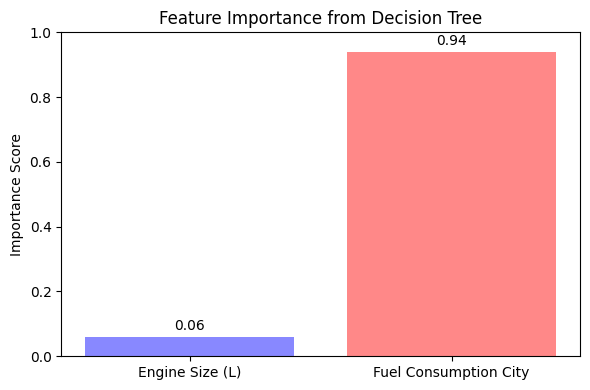

In [ ]:
# Bar Chart: Feature Importances

import matplotlib.pyplot as plt

# Use your model's feature importances
features = ["Engine Size (L)", "Fuel Consumption City"]
importances = [0.0601, 0.9399]

plt.figure(figsize=(6, 4))
bars = plt.bar(features, importances, color=["#8888ff", "#ff8888"])
plt.title("Feature Importance from Decision Tree")
plt.ylabel("Importance Score")
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')

plt.tight_layout()
plt.show()

---------------------------------------------------
Fuel Consumption vs CO2 Emissions Scatterplot

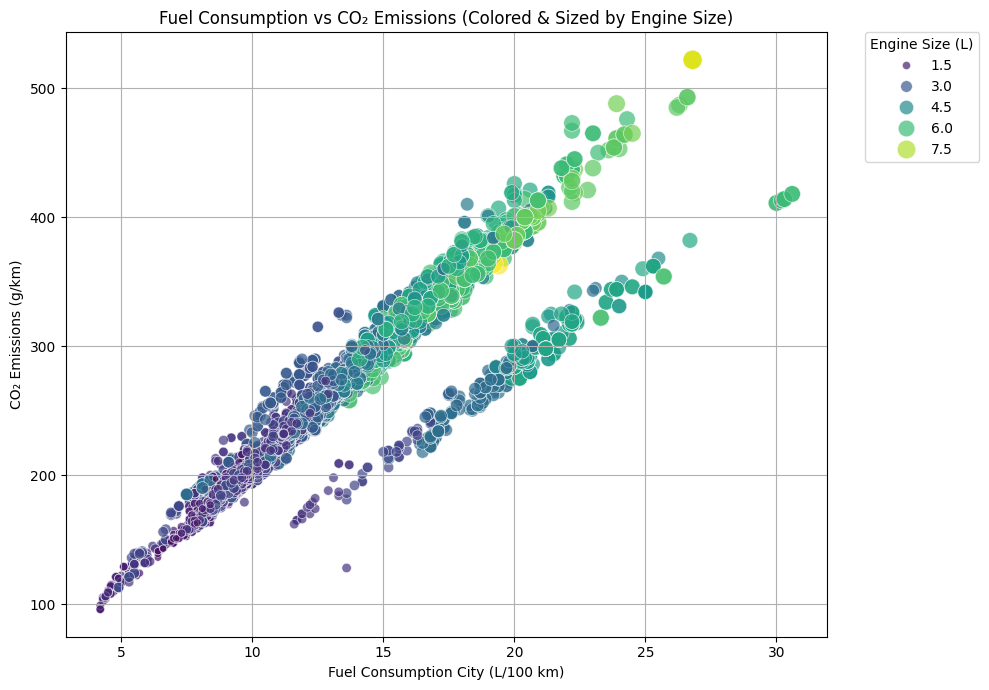

In [ ]:
# Scatterplot: Fuel Consumption vs CO2 Emissions

import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas (subset if dataset is large)
df_pd = car_cnt_df.select("Fuel Consumption City (L/100 km)", "CO2 Emissions(g/km)", "Engine Size(L)").toPandas()

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x="Fuel Consumption City (L/100 km)",
    y="CO2 Emissions(g/km)",
    hue="Engine Size(L)",        # Color points by Engine Size
    size="Engine Size(L)",       # Size points by Engine Size
    sizes=(20, 200),             # Point size range (adjust as needed)
    palette="viridis",
    data=df_pd,
    alpha=0.7,
    edgecolor="w"
)

plt.title("Fuel Consumption vs CO₂ Emissions (Colored & Sized by Engine Size)")
plt.xlabel("Fuel Consumption City (L/100 km)")
plt.ylabel("CO₂ Emissions (g/km)")
plt.legend(title="Engine Size (L)", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.grid(True)
plt.tight_layout()
plt.show()

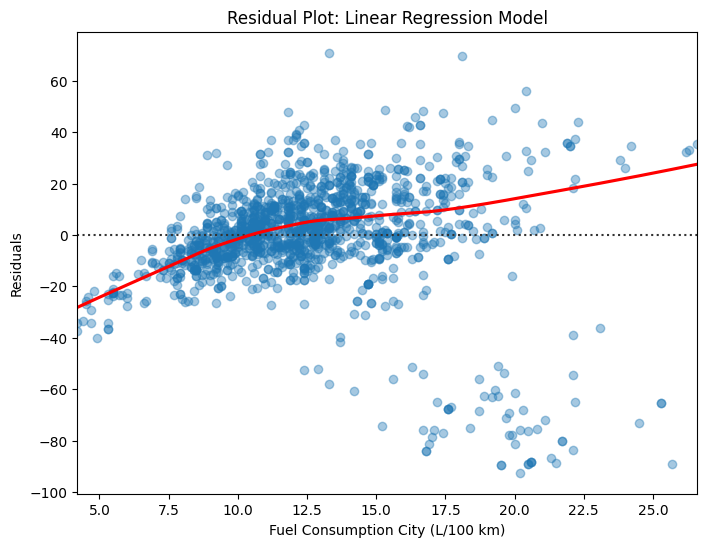

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for visualization
preds_pdf = linear_predictions.select(
    "Fuel Consumption City (L/100 km)",
    "CO2 Emissions(g/km)",
    "prediction"
).toPandas()

# Calculate residuals
preds_pdf["residuals"] = preds_pdf["CO2 Emissions(g/km)"] - preds_pdf["prediction"]

# Plot residuals
plt.figure(figsize=(8, 6))
sns.residplot(
    x=preds_pdf["Fuel Consumption City (L/100 km)"],
    y=preds_pdf["residuals"],
    lowess=True,
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"}
)
plt.xlabel("Fuel Consumption City (L/100 km)")
plt.ylabel("Residuals")
plt.title("Residual Plot: Linear Regression Model")
plt.show()


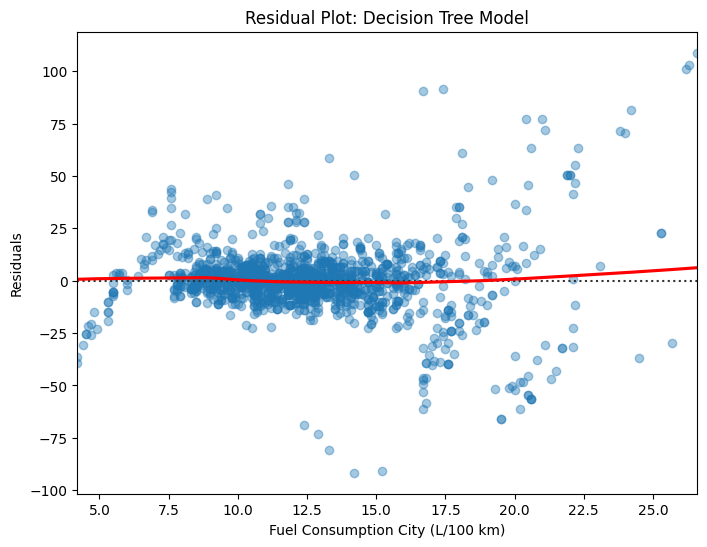

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for visualization
preds_pdf = predictions_df_DT.select(
    "Fuel Consumption City (L/100 km)",
    "CO2 Emissions(g/km)",
    "prediction"
).toPandas()

# Calculate residuals
preds_pdf["residuals"] = preds_pdf["CO2 Emissions(g/km)"] - preds_pdf["prediction"]

# Plot residuals
plt.figure(figsize=(8, 6))
sns.residplot(
    x=preds_pdf["Fuel Consumption City (L/100 km)"],
    y=preds_pdf["residuals"],
    lowess=True,
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"}
)
plt.xlabel("Fuel Consumption City (L/100 km)")
plt.ylabel("Residuals")
plt.title("Residual Plot: Decision Tree Model")
plt.show()
